In [3]:
import scanpy as sc
import os
import requests
import gzip
import shutil
from tqdm import tqdm
from anndata import AnnData as ad
import pandas as pd
import numpy as np

In [6]:
from celldreamer.paths import DATA_DIR

Read dataset 

In [16]:
def load_dataset(path, url, new_name=None):
    # Check if the file exists at the specified path
    if not os.path.exists(path):
        # If not, download the file from the URL
        print(f"Dataset not found at {path}. Downloading from {url}...")
        gz_path = path + '.gz'  # Temporary path for the compressed file
        response = requests.get(url, stream=True)

        # Get the total file size for progress bar
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kilobyte

        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(gz_path, 'wb') as f:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()

        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, something went wrong")

        print("Download complete. Decompressing the file...")

        # Decompress the .gz file
        with gzip.open(gz_path, 'rb') as f_in:
            with open(path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        os.remove(gz_path)  # Remove the compressed file
        print("Decompression complete.")

    # Rename the dataset file if new_name is provided
    if new_name:
        os.rename(path, new_name)
        path = new_name

    # Load the dataset using Scanpy
    dataset = sc.read_h5ad(path)
    return dataset

dataset_path = os.path.join(DATA_DIR, 'raw', 'neurips.h5ad')
dataset_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE194122&format=file&file=GSE194122%5Fopenproblems%5Fneurips2021%5Fcite%5FBMMC%5Fprocessed%2Eh5ad%2Egz'

adata = load_dataset(path=dataset_path, url=dataset_url, new_name=dataset_path)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Save counts 

In [17]:
adata.layers["X_counts"] = adata.layers["counts"].copy()
del adata.layers["counts"]

In [18]:
sc.pp.filter_genes(adata, min_cells=10)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Preprocess

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [20]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


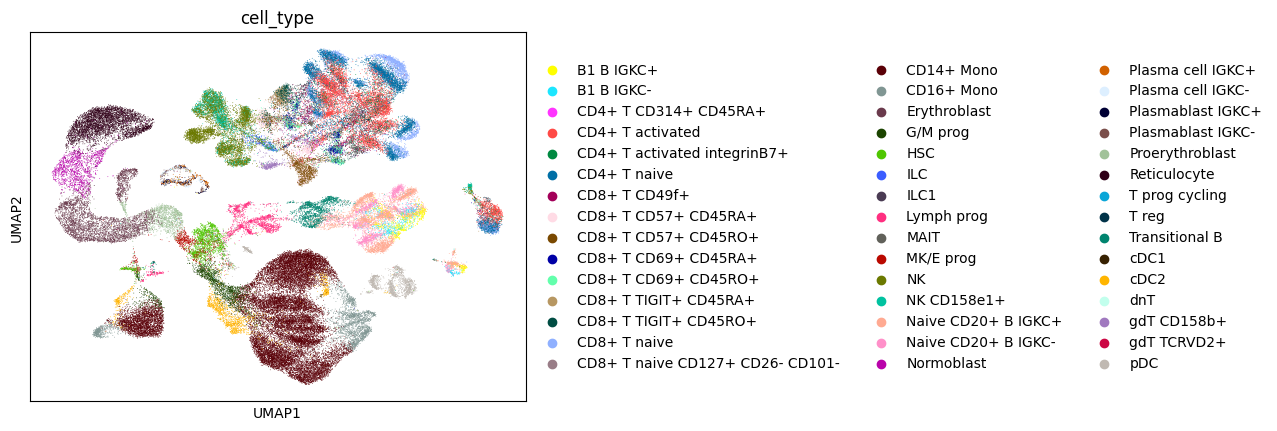

In [21]:
sc.pl.umap(adata, color=["cell_type"])

## Train test split

In [24]:
# Generate random indices for train and test sets
total_samples = adata.n_obs
train_frac = 0.8
train_size = int(total_samples * train_frac)
train_indices = np.random.choice(total_samples, size=train_size, replace=False)
test_indices = np.setdiff1d(np.arange(total_samples), train_indices)

# Separate data into train and test sets by indexing the Anndata object
train_adata = adata[train_indices, :]
test_adata = adata[test_indices, :]

In [25]:
train_adata

View of AnnData object with n_obs × n_vars = 72208 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'dataset_id', 'genome', 'organism', 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'distances', 'connectivities'

In [26]:
test_adata

View of AnnData object with n_obs × n_vars = 18053 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'dataset_id', 'genome', 'organism', 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'distances', 'connectivities'

In [27]:
adata

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'dataset_id', 'genome', 'organism', 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'distances', 'connectivities'

## Save

In [28]:
# sc.AnnData.write_h5ad(adata, DATA_DIR / "processed_full_genome" / "neurips" / "neurips.h5ad")

In [29]:
# sc.AnnData.write_h5ad(test_adata, DATA_DIR / "processed_full_genome" / "neurips" / "neurips_test.h5ad")

In [30]:
# sc.AnnData.write_h5ad(train_adata, DATA_DIR / "processed_full_genome" / "neurips" / "neurips_train.h5ad")

## Run highly variable gene selection

In [17]:
adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "neurips" / "neurips.h5ad")
train_adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "neurips" / "neurips_train.h5ad")
test_adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "neurips" / "neurips_test.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="X_counts",
    subset=False,
)

In [19]:
train_adata.var = adata.var
test_adata.var = adata.var

In [20]:
sc.AnnData.write_h5ad(adata, DATA_DIR / "processed_full_genome" / "neurips" / "neurips.h5ad")
sc.AnnData.write_h5ad(test_adata, DATA_DIR / "processed_full_genome" / "neurips" / "neurips_test.h5ad")
sc.AnnData.write_h5ad(train_adata, DATA_DIR / "processed_full_genome" / "neurips" / "neurips_train.h5ad")

In [7]:
adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "neurips" / "neurips.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata.obs.columns

Index(['GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors',
       'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts',
       'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order',
       'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality',
       'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType',
       'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker',
       'is_train'],
      dtype='object')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


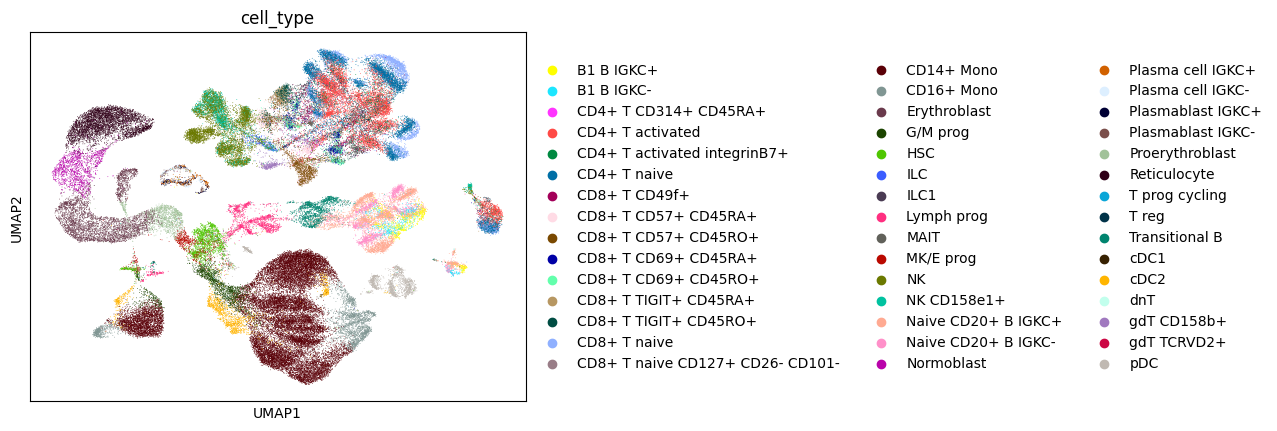

In [13]:
sc.pl.umap(adata, color="cell_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


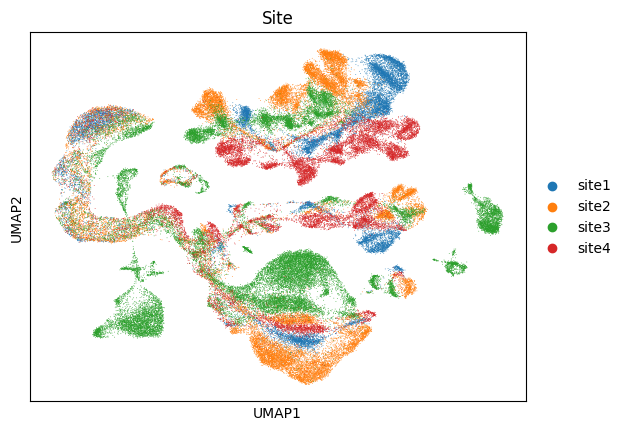

In [16]:
sc.pl.umap(adata, color="Site")